Датасет содержит информацию о различных наименованиях вина. Задачи анализа — ответить на следующие вопросы: 
    1) Какие вина стоит приобрести в коллекцию?
    2) Какие страны производят наибольшее количество наименований вина? 
    3) Какие показатели влияют на цену вина? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_red = pd.read_csv('Red.csv', sep = ',')

In [3]:
df_red.info() 
#по выведенным данным видим, что в датасете нет ненулевых значений. Датасет содержит 8 колонок и 8666 строк. 
#В датасете 3 типа переменных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 8 columns):
Name               8666 non-null object
Country            8666 non-null object
Region             8666 non-null object
Winery             8666 non-null object
Rating             8666 non-null float64
NumberOfRatings    8666 non-null int64
Price              8666 non-null float64
Year               8666 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 541.7+ KB


In [4]:
df_red.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [5]:
df_red.describe() #получим статистическую информацию о датасете

,Rating,NumberOfRatings,Price
count,8666.000000,8666.000000,8666.000000
mean,3.890342,415.287445,39.145065
std,0.308548,899.726373,84.936307
min,2.500000,25.000000,3.550000
25%,3.700000,66.000000,10.680000
50%,3.900000,157.000000,18.200000
75%,4.100000,401.000000,38.142500
max,4.800000,20293.000000,3410.790000


# Какие вина стоит приобрести в коллекцию?

In [6]:
#Создадим бинарную переменную "Collection". 
#Туда попадут вина, которые удовлетворяют следующим условиям: исключительно высокая цена, рейтинг выше 4.5 и возраст старше 10 лет. 

1. Работаем с показателем Price

In [7]:
#разделим вина на категории по ценам. для этого получим статистическую информацию о ценах. видим, что минимальная цена —  3.55, 
#максимальная — 3410,79, а средняя — 39,15. При этом 75% наименований имеют цену не выше 38,14
df_red['Price'].describe() 

count    8666.000000
mean       39.145065
std        84.936307
min         3.550000
25%        10.680000
50%        18.200000
75%        38.142500
max      3410.790000
Name: Price, dtype: float64

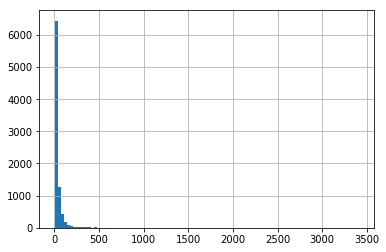

In [8]:
df_red['Price'].hist(bins = 100) #чтобы понять, на какие категории можно разделить данные, построим гистограмму

In [9]:
q1 = df_red['Price'].quantile(0.25)
q3 = df_red['Price'].quantile(0.75)
iqr = q3 - q1
print (iqr)

27.4625


In [10]:
iqr_outlier_threshold_bottom = q1 - 1.5 * iqr
iqr_outlier_threshold_up = q3 + 1.5 * iqr
print(iqr_outlier_threshold_bottom)
print(iqr_outlier_threshold_up)
#отрицательное значение —> значит, слева от медианы не будет выбросов

-30.513749999999995
79.33624999999999


In [11]:
df_red[df_red['Price'] > iqr_outlier_threshold_up].shape #в нашем датасете 824 выброса по цене —> почти 10% от всех значений

(824, 8)

In [12]:
df_red[df_red['Price'] > iqr_outlier_threshold_up]['Country'].value_counts() 
#проверим, по каким странам больше всего выбросов —> в каких странах вина дороже 75% других наименований вин. 
#Топ-3: Франция, Италия, США

France           436
Italy            200
United States     61
Spain             49
Australia         25
Chile             15
Argentina         10
South Africa       9
Germany            5
New Zealand        5
Austria            4
Portugal           4
Moldova            1
Name: Country, dtype: int64

In [13]:
#проверим разброс по рейтингу
df_red[df_red['Price'] > iqr_outlier_threshold_up]['Rating'].value_counts() 
#больше всего дорогих вин приходится на рейтинг 4.3, 4.4 и 4.2

4.3    157
4.4    153
4.2    141
4.5    114
4.6     95
4.1     74
4.0     39
4.7     26
3.9     14
4.8      6
3.8      4
3.7      1
Name: Rating, dtype: int64

In [14]:
#наконец, проверим разброс по году
df_red[df_red['Price'] > iqr_outlier_threshold_up]['Year'].value_counts()
#больше всего выбросов по цене — в 2015, 2016 и 2013 гг.

2015    111
2016    107
2013     95
2014     82
2010     61
2005     60
2011     51
2012     50
2017     49
2009     30
2008     25
2006     19
2004     13
2007     13
2000     10
1999      9
2001      5
1998      4
2003      4
2002      4
1995      4
1997      3
1992      3
1996      2
2018      2
1990      2
1989      2
1991      1
1988      1
N.V.      1
1993      1
Name: Year, dtype: int64

In [15]:
#по графику видим, что все вина по ценам можно разделить на группы:
def get_price_cat(Price):
    if Price <= 50:
        return 'Low'
    elif Price <= 200:
        return 'Middle'
    elif Price <= 500:
        return 'High'
    elif Price <= 3500:
        return 'Exceptional'
    else: 
        return Price

In [16]:
df_red['Price category'] = df_red['Price'].apply(get_price_cat) #присваиваем переменной имя

In [17]:
df_red.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Price category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,Middle
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,Low
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,Low
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,Low
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Low


In [18]:
df_red['Price category'] = pd.Categorical(df_red['Price category']) #обозначим, что это категориальная переменная

In [19]:
df_red['Price category'].value_counts()

Low            7139
Middle         1328
High            155
Exceptional      44
Name: Price category, dtype: int64

2. Работаем с показателем Rating

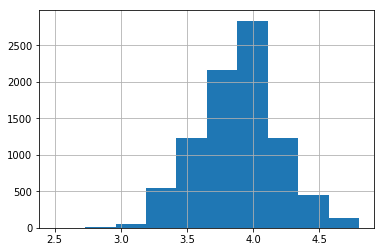

In [20]:
df_red['Rating'].hist()

In [21]:
df_red['Rating'].describe() #разделим вина на категории по рейтингу. 
#для этого получим статистическую информацию о рейтинге. видим, что минимальный показатель —  2.5, 
#максимальный — 4.8, а средний — 3.89. При этом 75% наименований имеют цену не выше 4.1

count    8666.000000
mean        3.890342
std         0.308548
min         2.500000
25%         3.700000
50%         3.900000
75%         4.100000
max         4.800000
Name: Rating, dtype: float64

In [22]:
df_red['Rating'].apply(lambda x:'Higher than 4.5' if x >= 4.5 else 0).value_counts() 
#проверяем, сколько наименований имеют рейтинг выше 4.5

0                  8379
Higher than 4.5     287
Name: Rating, dtype: int64

In [23]:
df_red['High rating'] = df_red['Rating'].apply(lambda x:'Higher than 4.5' if x >= 4.5 else 0)

In [24]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 10 columns):
Name               8666 non-null object
Country            8666 non-null object
Region             8666 non-null object
Winery             8666 non-null object
Rating             8666 non-null float64
NumberOfRatings    8666 non-null int64
Price              8666 non-null float64
Year               8666 non-null object
Price category     8666 non-null category
High rating        8666 non-null object
dtypes: category(1), float64(2), int64(1), object(6)
memory usage: 618.1+ KB


3. Работаем с показателем Year

In [25]:
df_red['Year'].value_counts()

2016    1776
2017    1558
2015    1396
2018    1099
2014     798
2013     564
2012     371
2011     278
2010     174
2005     154
2019     116
2009      84
2008      80
2006      44
2007      43
2004      27
2000      19
1999      15
2001      12
2003      11
N.V.       8
2002       7
1997       7
1998       6
1996       5
1995       4
1992       3
1990       2
1989       2
1988       1
1991       1
1993       1
Name: Year, dtype: int64

In [26]:
#по info выше мы увидели, что показатель Year — integer, что будет мешать нам сравнивать вина по степени винтажности. 
#Более того, по выводу выше видно, что там есть значение N.V., что означает nonvintage wine — смесь вин 2 и более лет. 
#Введем вместо этого показателя любое число, например, 2030 год — его точно не встречалось в датасете

df_red['Year'] = df_red['Year'].replace('N.V.', 2030)
df_red['Year'] = df_red['Year'].astype('int')

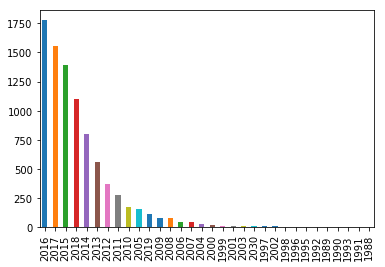

In [27]:
df_red['Year'].value_counts().plot(kind = 'bar')

In [28]:
def get_year_cat(Year):
    if Year >= 2020:
        return 'Young'
    elif Year >= 2018:
        return 'Aged'
    elif Year >= 2015:
        return 'Vintage'
    elif Year >= 2010:
        return 'Collection'
    else: 
        return Year

In [29]:
df_red['Year category'] = df_red['Year'].apply(get_year_cat) #присваиваем переменной имя

In [30]:
df_red['Year category'] = pd.Categorical(df_red['Year category']) #обозначим, что это категориальная переменная

In [31]:
df_red.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Price category,High rating,Year category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,Middle,0,Collection
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,Low,0,Vintage
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,Low,0,Vintage
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,Low,0,Aged
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Low,0,Vintage


In [32]:
np.where((df_red['Price category'] == 'Exceptional') &
         (df_red['High rating'] == 'Higher than 4.5') &
         (df_red['Year category'] == 'Collection'), 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
df_red['Wine to collect'] = np.where((df_red['Price category'] == 'Exceptional') &
         (df_red['High rating'] == 'Higher than 4.5') &
         (df_red['Year category'] == 'Collection'), 1, 0)

In [34]:
df_red['Wine to collect'].value_counts()
#итог — 13 наименований из списка удовлетворяют критериям коллекционного вина

0    8653
1      13
Name: Wine to collect, dtype: int64

In [35]:
df_red.head() #проверим

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Price category,High rating,Year category,Wine to collect
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,Middle,0,Collection,0
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,Low,0,Vintage,0
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,Low,0,Vintage,0
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,Low,0,Aged,0
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Low,0,Vintage,0


In [36]:
 df_red.info() #проверим типа данных столбцов High rating и Wine to collect, чтобы в дальнейшем он не препятствовал работе. 
#Это int, а нужно boolean. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 12 columns):
Name               8666 non-null object
Country            8666 non-null object
Region             8666 non-null object
Winery             8666 non-null object
Rating             8666 non-null float64
NumberOfRatings    8666 non-null int64
Price              8666 non-null float64
Year               8666 non-null int64
Price category     8666 non-null category
High rating        8666 non-null object
Year category      8666 non-null category
Wine to collect    8666 non-null int64
dtypes: category(2), float64(2), int64(3), object(5)
memory usage: 695.0+ KB


In [37]:
df_red['Wine to collect'] = df_red['Wine to collect'].astype(bool)

In [38]:
df_red['High rating'] = df_red['Wine to collect'].astype(bool)

In [39]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 12 columns):
Name               8666 non-null object
Country            8666 non-null object
Region             8666 non-null object
Winery             8666 non-null object
Rating             8666 non-null float64
NumberOfRatings    8666 non-null int64
Price              8666 non-null float64
Year               8666 non-null int64
Price category     8666 non-null category
High rating        8666 non-null bool
Year category      8666 non-null category
Wine to collect    8666 non-null bool
dtypes: bool(2), category(2), float64(2), int64(2), object(4)
memory usage: 576.6+ KB


# Какие страны производят больше всего наименований вина?

In [40]:
df_red['Country'].nunique() #просмотрим, вина из скольки стран есть в датасете

30

In [41]:
df_red['Country'].value_counts() #просмотрим, какие это страны

Italy            2650
France           2256
Spain            1142
South Africa      500
United States     374
Chile             326
Germany           248
Australia         246
Argentina         246
Portugal          230
Austria           220
New Zealand        63
Brazil             40
Romania            23
Lebanon            15
Israel             13
Greece             13
Switzerland        12
Hungary             9
Slovenia            8
Moldova             8
Turkey              6
Georgia             5
Uruguay             4
Bulgaria            2
Canada              2
Croatia             2
China               1
Mexico              1
Slovakia            1
Name: Country, dtype: int64

In [42]:
producer_list = {'Production':df_red['Country'].value_counts()} 
#создадим словарь, в котором присвоим стране объем производимого вина

In [43]:
df_producer = pd.DataFrame.from_dict(producer_list) #создадим датафрейм, чтобы работать с этим словарем

In [44]:
df_producer.head() #проверяем, корректно ли записался датафрейм

,Production
Italy,2650
France,2256
Spain,1142
South Africa,500
United States,374


In [45]:
df_producer = df_producer.reset_index(level=0) #записываем название страны не в индекс, а в колонку

In [46]:
df_producer.head() #проверяем, корректно ли записался датафрейм

,index,Production
0,Italy,2650
1,France,2256
2,Spain,1142
3,South Africa,500
4,United States,374


In [47]:
df_producer.rename(columns = {'index':'Country'}, inplace = True) #переименовываем колонку

In [48]:
df_producer.head() #проверяем, корректно ли записался датафрейм

,Country,Production
0,Italy,2650
1,France,2256
2,Spain,1142
3,South Africa,500
4,United States,374


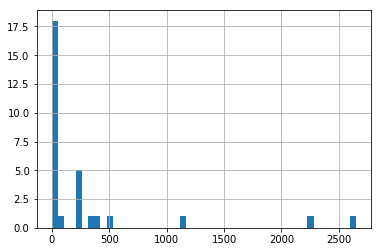

In [49]:
#чтобы понять, на какие категории можно разделить страны-производители вина по объему произведенного вина, построим гистограмму
df_producer['Production'].hist(bins = 50)

In [50]:
#по графику видим, что все страны можно разделить на группы:
def get_country_cat(Production):
    if Production <= 200:
        return 'Низкий'
    elif Production <= 1000:
        return 'Умеренный'
    elif Production <= 2000:
        return 'Высокий'
    elif Production <= 3000:
        return 'Очень высокий'
    else: 
        return Production

In [51]:
df_producer['Production cat'] = df_producer['Production'].apply(get_country_cat) #присваиваем переменной имя

In [52]:
df_producer['Production cat'] = pd.Categorical(df_producer['Production cat']) #обозначим, что это категориальная переменная

In [53]:
df_producer['Production cat'].value_counts()

Низкий           19
Умеренный         8
Очень высокий     2
Высокий           1
Name: Production cat, dtype: int64

In [54]:
top_countries = df_red.Country.value_counts()[:13] 
#выделим топ стран-производителей вина. для этого возьмем три категории: высокий, очень высокий и умеренный

In [55]:
print(top_countries)

Italy            2650
France           2256
Spain            1142
South Africa      500
United States     374
Chile             326
Germany           248
Australia         246
Argentina         246
Portugal          230
Austria           220
New Zealand        63
Brazil             40
Name: Country, dtype: int64


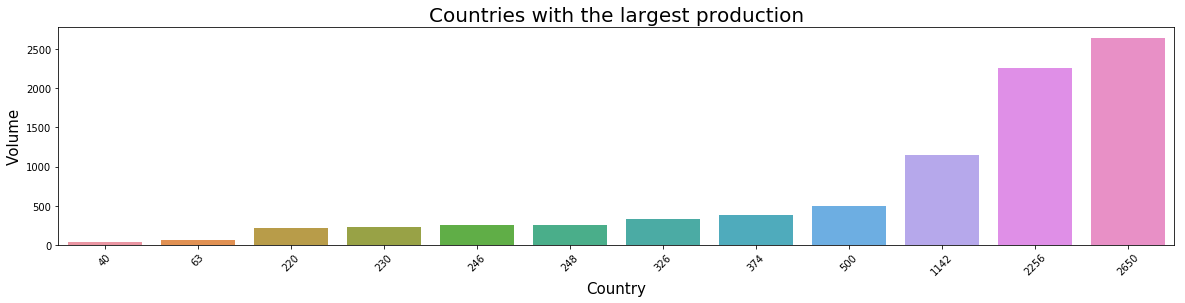

In [56]:
#создадим диаграмму, которая будет иллюстрировать топ-страны по объему произведенного вина. 

plt.figure(figsize=(20,4))

graph = sns.barplot(data = top_countries, x = top_countries.index, y = top_countries)
graph.set_title('Countries with the largest production', fontsize=20)
graph.set_xlabel('Country', fontsize=15)
graph.set_ylabel('Volume', fontsize=15)
plt.xticks(rotation=45)

plt.show()

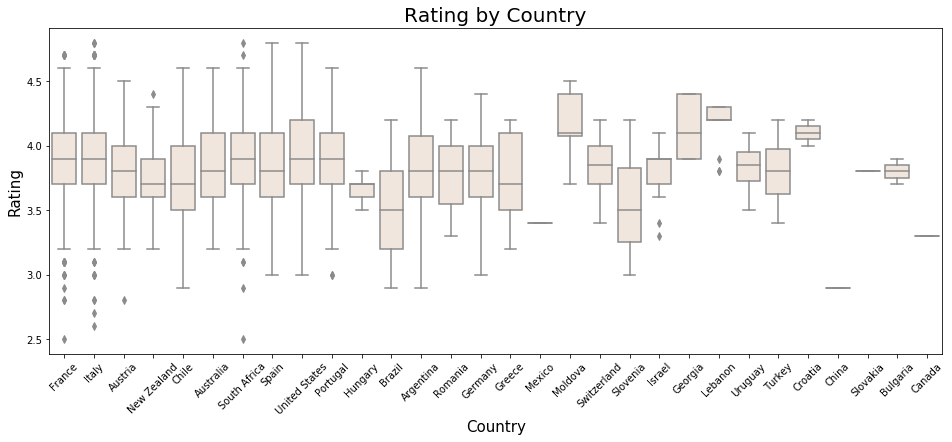

In [57]:
#построим диаграмму типа "ящик с усами", чтобы увидеть, как распределяются вина по рейтингам в зависимости от стран. 

plt.figure(figsize = (16,6))

graph = sns.boxplot(x = 'Country', y = 'Rating',
                 data = df_red,
                 color='#f3e6db')
graph.set_title("Rating by Country", fontsize=20)
graph.set_xlabel("Country", fontsize=15)
graph.set_ylabel("Rating", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())
plt.xticks(rotation=45)

plt.show()

#Из нее мы видим, что наибольший разброс — у вин из Бразилии, Греции и Словении, тогда как наименьший — 
#у Венгрии, Ливана, Хорватии и Болгарии 

# Какие факторы влияют на цену вина?

In [58]:
#есть ли корреляция между ценой вина и его рейтингом? от чего зависит цена вина?
#прежде чем составлять корр. матрицу, исключим признак Wine to collect, тк он включает в себя остальные признаки
df_red1 = df_red.drop(['Wine to collect'], axis = 1)

In [59]:
df_red1.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Price category,High rating,Year category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,Middle,False,Collection
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,Low,False,Vintage
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,Low,False,Vintage
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,Low,False,Aged
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Low,False,Vintage


In [60]:
corr_m = df_red1.corr()
corr_m

,Rating,NumberOfRatings,Price,Year,High rating
Rating,1.000000,0.075216,0.451060,-0.336983,0.093019
NumberOfRatings,0.075216,1.000000,0.006407,0.004018,-0.007111
Price,0.451060,0.006407,1.000000,-0.360574,0.472242
Year,-0.336983,0.004018,-0.360574,1.000000,-0.037652
High rating,0.093019,-0.007111,0.472242,-0.037652,1.000000


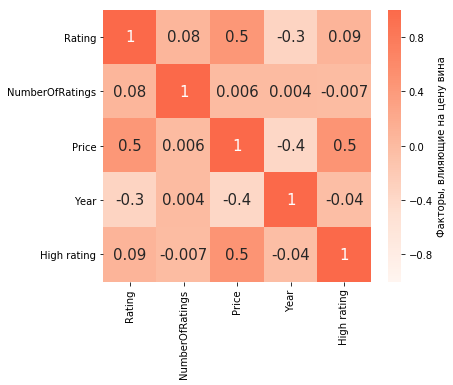

In [61]:
plt.figure(figsize = (6,5))
matrix = np.triu(corr_m)
sns.heatmap(corr_m, annot = True,
            center = 1, 
            linecolor = 'yellow', 
            annot_kws = {'size':15}, 
            cmap = 'Reds', 
            vmax = 1, 
            vmin = -1,
            fmt = '.1g',
            cbar_kws = {'label':'Факторы, влияющие на цену вина'}) 
#по корреляционной матрице видим, что наибольшее влияние на цену вина оказывает рейтинг. При этом корреляция все равно слабая

Text(0,0.5,'Цена на вино (долл.)')

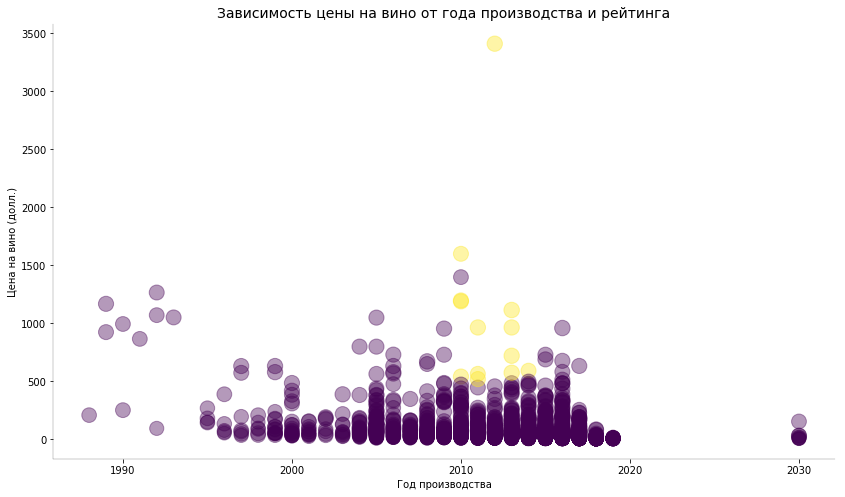

In [62]:
#проследим, как год производства вина влияет на цену
fig, ax = plt.subplots(figsize=(14,8))
graph = ax.scatter(df_red['Year'], df_red['Price'], c = df_red['High rating'], s = df_red['Rating']*50, alpha = 0.4)

ax.set_title('Зависимость цены на вино от года производства и рейтинга', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.2)
ax.spines['bottom'].set_linewidth(0.2)
ax.set_xlabel('Год производства', fontsize=10)
ax.set_ylabel('Цена на вино (долл.)', fontsize=10)

#вывод — график подтверждает выводы корреляционной матрицы выше: зависимости между ценой и годом производства не наблюдается. 
#Однако отметим, что все вина с высоким рейтингом (выше 4,5) были произведены между 2010 и 2015 годом. 

Выводы: 
    1) 13 наименований из датасета удовлетворяют критериям коллекционного вина. 
    2) Топ-3 производителей вина: Италия, Франция, Испания. Наибольший разброс в качестве вина, согласно оценкам — у вин из Бразилии, Греции и Словении, тогда как наименьший — у Венгрии, Ливана, Хорватии и Болгарии. 
    3) Наибольшее влияние на цену вина оказывает рейтинг. При этом корреляция все равно слабая. Все вина с высоким рейтингом (выше 4,5) были произведены между 2010 и 2015 годом. 